In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as plb
import h5py
import pandas as pd
import scikitplot as skplt
from scipy import asarray as ar,exp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['xtick.labelsize']  = 14
plt.rcParams['ytick.labelsize']  = 14
plt.rcParams['axes.labelsize']   = 14
plt.rcParams['axes.titlesize']   = 16
plt.rcParams['legend.fontsize']  = 14

In [0]:
def loadh5File(filename):
    """Load h5 database and return signal and time arrays.

    >> loadh5File("input.h5")
    data, time
    """
    h5 = h5py.File(filename,'r')
    print(list(h5.keys()))
    time = np.array(h5['time'])
    data = np.array(h5['data'])
    print(np.shape(data))
    m = np.shape(data)
    m, n = m[0]*m[1], m[2]
    signal = np.zeros([m,n])
    k = 0
    for i in range(len(data)):
        for j in range(len(data[i])):
            signal[k] = data[i][j]
            k += 1
    print(np.shape(signal))
    #return data, time
    return signal, time


def removeOffset(data, a, b):
    """Remove signal offset.

    a: número de amostras utilizadas.

    >>> removeOffset(signalArray)
    signalWithoutOffset
    """
    for i in range(len(data)):
        data[i] = data[i] - np.mean(data[i][a:b])
    return data


def plotMeanSignals(signal):
    ind  = [n*100 for n in range(211)]
    m, n = np.shape(signal)
    signal_mean = np.zeros([210,n])
    for i in range(210):
        signal_mean[i] = np.mean(signal[ind[i]:ind[i+1]-1],axis=0)

    print(np.shape(signal_mean))

    fig = plt.figure(figsize=(7,5))
    plt.plot(signal_mean.T)
    #plt.grid()
    plt.xlabel('Amostras')
    plt.ylabel('Amplitude')
    plt.show()
    return


def chargeDist(signal, f, b):
    """Charge estimation.

    f: sampling frequency (ex.: 5GS/s);
    b: histogram bins

    >>> chargeEst(data, 5*10**9, 100)
    qest
    """
    fesc  = 10**12               #Fator de conversão de escala
    req   = 50                   #Resistência equivalente vista pela PMT
    dt    = 1/f                  #Frequência de aquisição
    qest  = (fesc/req)*(sum(signal.T*dt))
    yh,xh = np.histogram(qest,bins=b)
    xh    = np.delete(xh, -1)
    return qest, xh, yh


def signalAmp(signal, flag):
    """Get signal amplitudes.

    flag == 1 -> return column vector

    >>> signalAmp(data)
    ampArray
    """
    pico = np.max(signal, axis=1)
    if flag == 1:
        pico = np.reshape(pico, (-1,1))
    return pico


def linearCoef(pico, qest):
    """Amplitude x Charge linear coefficients.

    >>> linearCoef(pico, qest)
    pfit, lcov
    """ 
    pfit,lcov = np.polyfit(pico, qest, 1, cov='true')
    print("Coeficientes:\t\t", pfit)
    print("Matriz de covariância:  ", lcov[0], "\n\t\t\t", lcov[1])
    return pfit, lcov


def quantSinal(db_sinais):
    db_sinais = np.round(db_sinais/(9.8*10**-3)) - 36 
    isat = np.where(np.max(db_sinais, axis=1) > 127)[0]
    for i in isat:
        ind = np.where(db_sinais[i,:] > 127)[0]
        db_sinais[i,ind] = 127
    return db_sinais + 36


def fwhm(signal):
    fwhm = np.zeros((signal.shape[0],1))
    for i in range(signal.shape[0]):
        dist = [d for d in range(signal.shape[1]) if signal[i][d] > max(signal[i])/2]
        fwhm[i] = max(dist) - min(dist)
    return fwhm

# Sinais de saída da front-end

- Taxa de aquisição: 1.25GS/s
- Offset: 11000 (REG)

## Pré-processamento

In [0]:
signal_fe, time_fe = loadh5File("offvalor_11000.0_3.5M.h5")
signal_fe = signal_fe[:,100:450]
print(np.shape(signal_fe))
signal_fe = removeOffset(signal_fe, 20, 40)
signal_fe = np.roll(signal_fe, -20)

['data', 'offvalue', 'time']
(210, 100, 500)
(21000, 500)
(21000, 350)


In [0]:
#from scipy import signal
#signal_fe = signal.filtfilt(np.ones(5)/5, 1, signal_fe,padlen=299)
#signal_fe = removeOffset(signal_fe, 20, 40)

(210, 350)


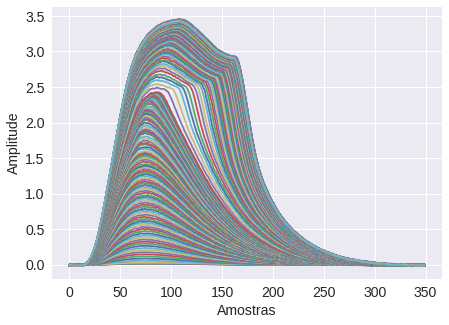

In [0]:
plotMeanSignals(signal_fe)

## Quantização dos sinais

Cada ADC equivale a 9.8 mV.

Pedestal médio observado no experimento: 36 ADC.

In [0]:
signal_fe = np.round(signal_fe/(9.8*10**-3)) - 36 

In [0]:
isat = np.where(np.max(signal_fe, axis=1) > 127)[0]
for i in isat:
    ind = np.where(signal_fe[i,:] > 127)[0]
    signal_fe[i,ind] = 127

In [0]:
# Retirando pedestal dos sinais após quantização
signal_fe = signal_fe + 36

(210, 350)


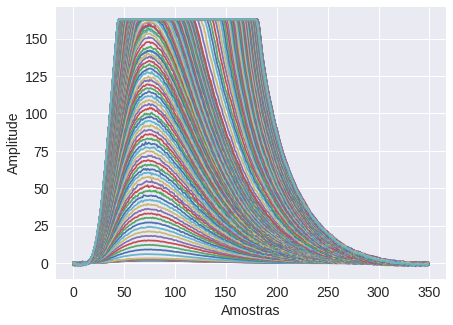

In [0]:
plotMeanSignals(signal_fe)

## Amplitude x Carga

In [0]:
fesc = 10**6
req = 50
dt = 1/(1.25*10**9)
qest_out = (fesc/req)*(sum(signal_fe.T*dt))
amp_out = np.max(signal_fe, axis=1)

In [0]:
ind = np.where(qest_out <= 0.25)
pfit_out,lcov_out = np.polyfit(qest_out[ind], amp_out[ind], 1, cov='true')
print("Coeficientes:\t\t", pfit_out)
print("Matriz de covariância:  ", lcov_out[0], "\n\t\t\t", lcov_out[1])

Coeficientes:		 [661.24021927   1.62280265]
Matriz de covariância:   [ 0.23899728 -0.02796989] 
			 [-0.02796989  0.00490264]


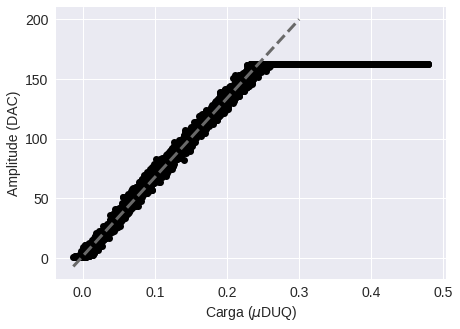

In [0]:
xfit_out = np.linspace(min(qest_out),0.3,100) 
yfit_out = pfit_out[0]*xfit_out + pfit_out[1]

fig = plt.figure(figsize=(7,5))

plt.plot(qest_out, amp_out, 'o')
plt.plot(xfit_out, yfit_out, linestyle='--',linewidth=3,label='Aquisição')
plt.xlabel('Carga ($\mu$DUQ)')
plt.ylabel('Amplitude (DAC)')

plt.show()

# Geração do Banco de Dados para classificação

## Classes de sinais

In [0]:
signal_out, time_out = loadh5File("offvalor_11000.0_3.5M.h5")
signal_out = signal_out[:,100:450]
#print(np.shape(signal_out))
signal_out = removeOffset(signal_out, 20, 40)
signal_out = np.roll(signal_out, -20)
signal_out.shape

['data', 'offvalue', 'time']
(210, 100, 500)
(21000, 500)


(21000, 350)

(210, 350)


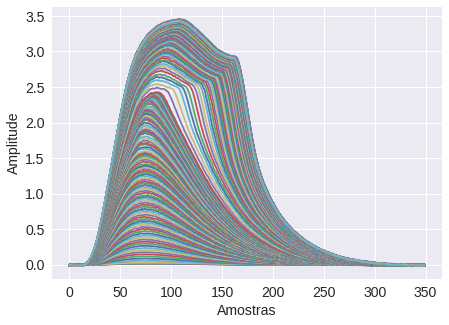

In [0]:
plotMeanSignals(signal_out)

In [0]:
# Separando sinais saturados e não saturados
signal_q = np.round(signal_out/(9.8*10**-3)) - 36
sig = signal_out[np.where(np.max(signal_q, axis=1) <= 127)[0]]
sat = signal_out[np.where(np.max(signal_q, axis=1) >  127)[0]]
del(signal_q)
print("Não saturados: ", sig.shape,"\n","   Saturados: ", sat.shape)

Não saturados:  (6807, 350) 
    Saturados:  (14193, 350)


In [0]:
# Sinais cortados
n = np.random.randint(3500,signal_out.shape[0],7000)   #Sortear 25k janelas a partir de 3500
ctd = np.zeros((7000, signal_out.shape[1]))
j = 0
for i in n:
    r   = np.random.randint(50,150)    # Número de índices deslocados
    ctd[j] = np.roll(signal_out[i],-r)
    ind = 350 - r
    ctd[j][ind:350] = np.std(signal_out[i][320:350])*np.random.randn(r)  #Adicionar ruído nas últimas amostras
    j += 1

print("Cortados: ", ctd.shape)

Cortados:  (7000, 350)


In [0]:
# Sinais com dois picos
n = np.random.randint(3500,signal_out.shape[0],7000)   #Sortear 25k janelas a partir de 3500
dpc = np.zeros((7000, signal_out.shape[1]))
j = 0
for i in n:
    k = np.random.randint(i//2,i-1000,1)[0]   #Sortear outra janela de amplitude menor  
    ind = np.where(np.roll(signal_out[i], 0)[50:200] < np.roll(signal_out[k],75)[50:200])[0]  #(-35, 40)
    while len(ind) == 0:
        k = np.random.randint(i//2,i-1000,1)[0]   
        ind = np.where(np.roll(signal_out[i], 0)[50:200] < np.roll(signal_out[k],75)[50:200])[0]
    l = ind[0] + 50
    dpc[j] = np.roll(signal_out[i],0)
    dpc[j][l:350] = np.roll(signal_out[k], 75)[l:350]
    j += 1

print("Com mais de um pico: ", dpc.shape)

Com mais de um pico:  (7000, 350)


In [0]:
#Salvando os bancos de dados em um arquivo .h5
hf = h5py.File('db_sinais.h5', 'w')   
hf.create_dataset('esperados', data=sig)
hf.create_dataset('saturados', data=sat)
hf.create_dataset('cortados' , data=ctd)
hf.create_dataset('doisPicos', data=dpc)
hf.close()

In [0]:
#Quantização dos sinais
sig = quantSinal(sig)
sat = quantSinal(sat)
ctd = quantSinal(ctd)
dpc = quantSinal(dpc)

In [0]:
# Excluindo sinais de baixa energia (Amplitude <= 5 ADC)
ind = np.where(np.max(sig, axis=1) >= 5)[0]
sig = sig[ind,:]
sig.shape

(5709, 350)

In [0]:
#Salvando os bancos de dados já quantizados em um arquivo .h5
hf = h5py.File('db_sinais_qtz.h5', 'w')   
hf.create_dataset('esperados', data=sig)
hf.create_dataset('saturados', data=sat)
hf.create_dataset('cortados' , data=ctd)
hf.create_dataset('doisPicos', data=dpc)
hf.close()

## Extração de parâmetros

- Amplitude
- Área
- Posição da Amplitude
- Largura à meia altura
- Label

In [0]:
#Sinais bons (label 1)
amp_sig  = np.max(sig, axis=1).reshape(-1,1)
area_sig = sum(sig.T).reshape(-1,1)
pAmp_sig = np.argmax(sig,axis=1).reshape(-1,1)
dist_sig = fwhm(sig)
lb_sig   = 1*np.ones((sig.shape[0],1))
db_sig   = np.concatenate((amp_sig, area_sig, pAmp_sig, dist_sig, lb_sig), axis=1)
db_sig.shape

(5709, 5)

In [0]:
#Sinais saturados (label 2)
amp_sat  = np.max(sat, axis=1).reshape(-1,1)
area_sat = sum(sat.T).reshape(-1,1)
pAmp_sat = np.argmax(sat,axis=1).reshape(-1,1)
dist_sat = fwhm(sat)
lb_sat   = 2*np.ones((sat.shape[0],1))
db_sat   = np.concatenate((amp_sat, area_sat, pAmp_sat, dist_sat,lb_sat), axis=1)
db_sat.shape

(14193, 5)

In [0]:
#Sinais cortados (label 3)
amp_ctd  = np.max(ctd, axis=1).reshape(-1,1)
area_ctd = sum(ctd.T).reshape(-1,1)
pAmp_ctd = np.argmax(ctd,axis=1).reshape(-1,1)
dist_ctd = fwhm(ctd)
lb_ctd   = 3*np.ones((ctd.shape[0],1))
db_ctd   = np.concatenate((amp_ctd, area_ctd, pAmp_ctd, dist_ctd, lb_ctd), axis=1)
db_ctd.shape

(7000, 5)

In [0]:
#Sinais com dois picos (label 4)
amp_dpc  = np.max(dpc, axis=1).reshape(-1,1)
area_dpc = sum(dpc.T).reshape(-1,1)
pAmp_dpc = np.argmax(dpc,axis=1).reshape(-1,1)
dist_dpc = fwhm(dpc)
lb_dpc   = 4*np.ones((dpc.shape[0],1))
db_dpc   = np.concatenate((amp_dpc, area_dpc, pAmp_dpc, dist_dpc, lb_dpc), axis=1)
db_dpc.shape

(7000, 5)

In [0]:
#Salvando os bancos de dados de parâmetros em um arquivo .h5
hf = h5py.File('db_sinais_par.h5', 'w')   
hf.create_dataset('esperados', data=db_sig)
hf.create_dataset('saturados', data=db_sat)
hf.create_dataset('cortados',  data=db_ctd)
hf.create_dataset('doisPicos', data=db_dpc)
hf.close()

## Dataframe

In [0]:
df = pd.DataFrame(np.concatenate((db_sig, db_sat, db_ctd, db_dpc), axis=0), 
                  columns=['Amp', 'Area', 'Pos_Amp', 'FWHM', 'Label'])
df.to_csv('DataFrame_Aqst.csv')
df.head()

,Amp,Area,Pos_Amp,FWHM,Label
0,5.0,1006.0,292.0,271.0,1.0
1,5.0,988.0,286.0,268.0,1.0
2,7.0,810.0,80.0,87.0,1.0
3,7.0,652.0,84.0,82.0,1.0
4,6.0,-67.0,69.0,63.0,1.0


# Load do banco de dados criado

In [0]:
#Sinais antes da quantização
h5 = h5py.File('db_sinais.h5','r')
print(list(h5.keys()))
sig = np.array(h5['esperados'])
sat = np.array(h5['saturados'])
ctd = np.array(h5['cortados'])
dpc = np.array(h5['doisPicos'])

['cortados', 'doisPicos', 'esperados', 'saturados']


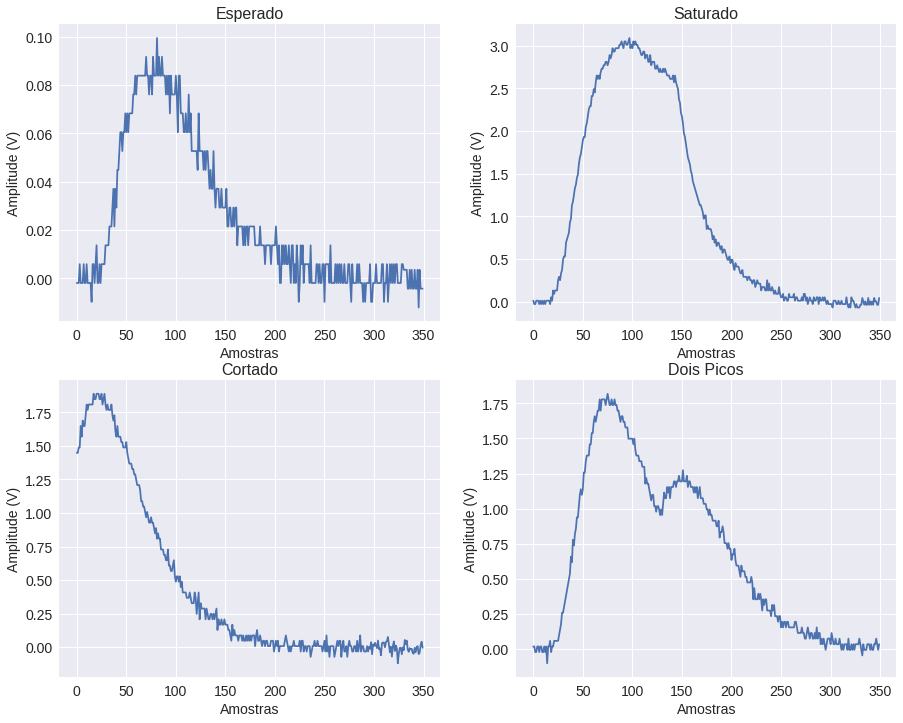

In [0]:
fig = plt.figure(figsize=(15,12))

fig.add_subplot(2,2,1)
plt.plot(sig[1250],)
plt.xlabel('Amostras')
plt.ylabel('Amplitude (V)')
plt.title('Esperado')

fig.add_subplot(2,2,2)
plt.plot(sat[6000],)
plt.xlabel('Amostras')
plt.ylabel('Amplitude (V)')
plt.title('Saturado')

fig.add_subplot(2,2,3)
plt.plot(ctd[2500],)
plt.xlabel('Amostras')
plt.ylabel('Amplitude (V)')
plt.title('Cortado')

fig.add_subplot(2,2,4)
plt.plot(dpc[2500],)
plt.xlabel('Amostras')
plt.ylabel('Amplitude (V)')
plt.title('Dois Picos')

plt.show()

In [0]:
#Sinais já quantizados
h5 = h5py.File('db_sinais_par.h5','r')
print(list(h5.keys()))
db_sig = np.array(h5['esperados'])
db_sat = np.array(h5['saturados'])
db_ctd = np.array(h5['cortados'])
db_dpc = np.array(h5['doisPicos'])

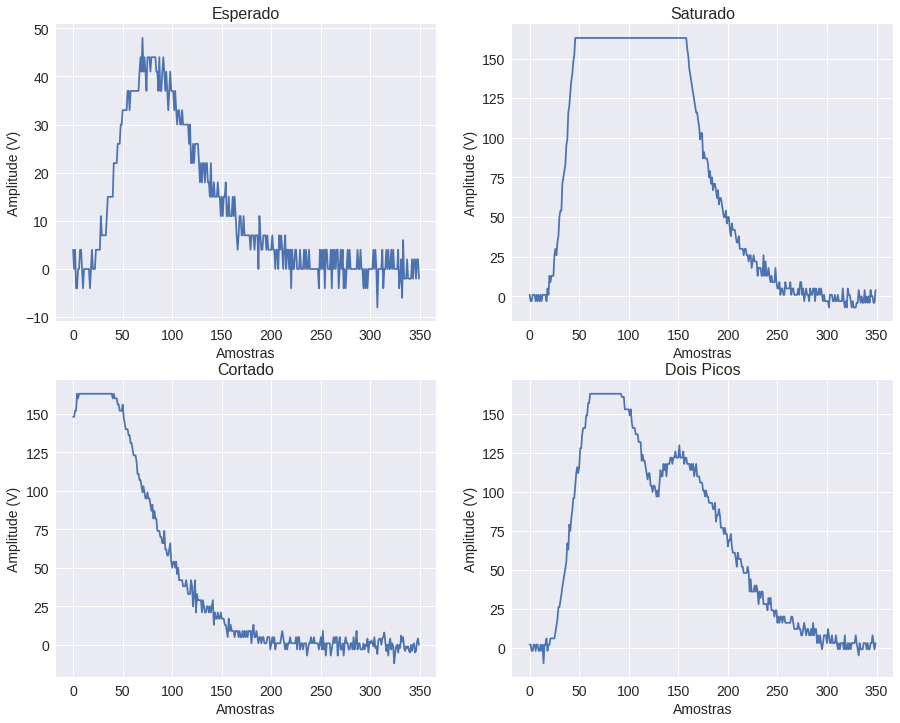

In [0]:
fig = plt.figure(figsize=(15,12))

fig.add_subplot(2,2,1)
plt.plot(sig[1250],)
plt.xlabel('Amostras')
plt.ylabel('Amplitude (V)')
plt.title('Esperado')

fig.add_subplot(2,2,2)
plt.plot(sat[6000],)
plt.xlabel('Amostras')
plt.ylabel('Amplitude (V)')
plt.title('Saturado')

fig.add_subplot(2,2,3)
plt.plot(ctd[2500],)
plt.xlabel('Amostras')
plt.ylabel('Amplitude (V)')
plt.title('Cortado')

fig.add_subplot(2,2,4)
plt.plot(dpc[2500],)
plt.xlabel('Amostras')
plt.ylabel('Amplitude (V)')
plt.title('Dois Picos')

plt.show()

# Análise dos parâmetros

In [3]:
#Load DataFrame
df = pd.read_csv('DataFrame_Aqst.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

,Amp,Area,Pos_Amp,FWHM,Label
0,5.0,1006.0,292.0,271.0,1.0
1,5.0,988.0,286.0,268.0,1.0
2,7.0,810.0,80.0,87.0,1.0
3,7.0,652.0,84.0,82.0,1.0
4,6.0,-67.0,69.0,63.0,1.0


## Amplitude das classes

Text(0, 0.5, 'Amplitude')

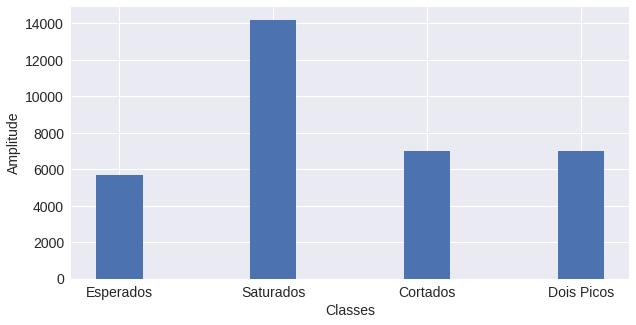

In [4]:
amp = np.array([])
for i in range(1,5):
    amp = np.append(amp, len(df.loc[(df['Label'] == i)]))

classes = ['Esperados', 'Saturados', 'Cortados', 'Dois Picos']
plt.figure(figsize=(10,5))
plt.bar(classes, amp, width=0.3)
plt.xlabel('Classes')
plt.ylabel('Amplitude')

## Comportamento dos parâmetros em cada classe

In [0]:
classes = ['Esperados', 'Saturados', 'Cortados', 'Dois Picos']

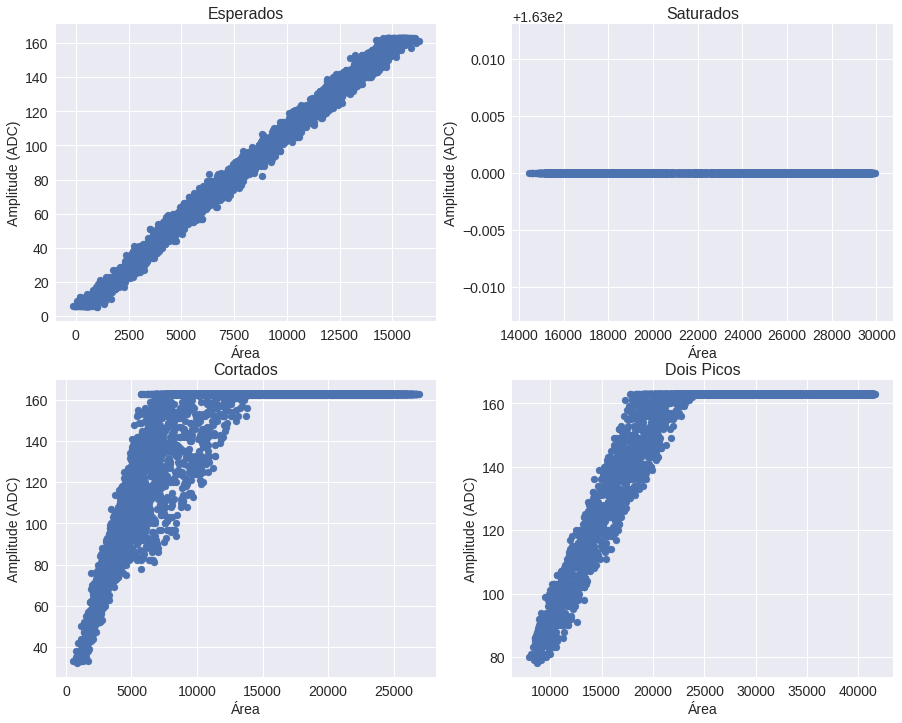

In [6]:
#Amplitude x Área (Plots individuais)
fig = plt.figure(figsize=(15,12))

for i in range(4):
    amp  = df["Amp"][df["Label"] == i+1]
    area = df["Area"][df["Label"] == i+1]
    fig.add_subplot(2,2,i+1)
    plt.scatter(area,amp, label=classes[i])
    plt.title(classes[i])
    plt.xlabel('Área')
    plt.ylabel('Amplitude (ADC)')

plt.show()

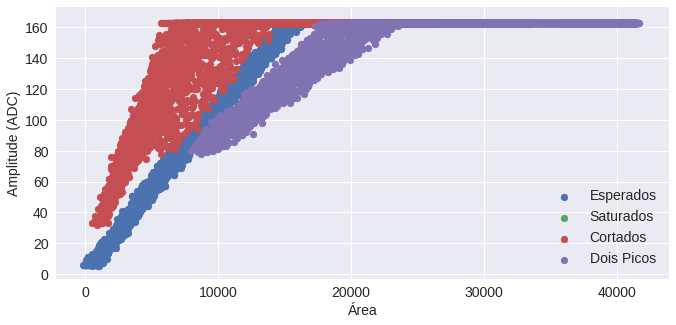

In [7]:
#Amplitude x Área
fig = plt.figure(figsize=(11,5))
for i in range(4):
    amp  = df["Amp"][df["Label"] == i+1]
    area = df["Area"][df["Label"] == i+1]
    plt.scatter(area,amp, label=classes[i])

plt.legend()
plt.xlabel('Área')
plt.ylabel('Amplitude (ADC)')
plt.show()

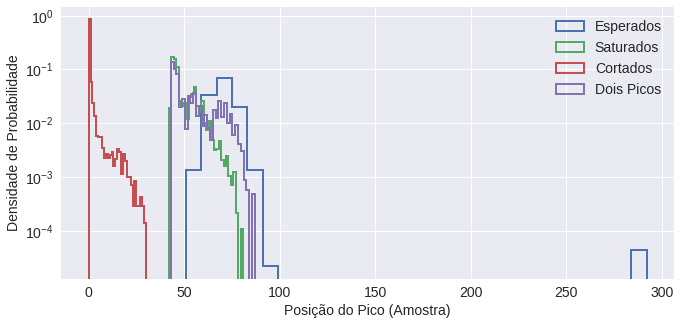

In [8]:
#Posição do pico
fig = plt.figure(figsize=(11,5))
for i in range(4):
    plt.hist(df["Pos_Amp"][df["Label"]==i+1],label = classes[i], bins = 30, density=True, fill = False,
             histtype= 'step',linewidth = 2.0)

plt.legend()
plt.xlabel('Posição do Pico (Amostra)')
plt.ylabel('Densidade de Probabilidade')
plt.yscale('log')
plt.show()

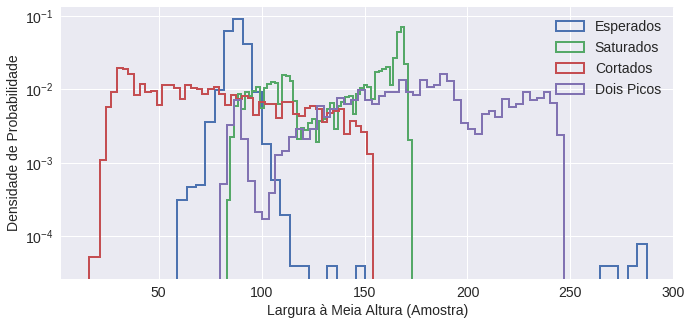

In [9]:
#Largura à meia altura
fig = plt.figure(figsize=(11,5))
for i in range(4):
    plt.hist(df["FWHM"][df["Label"]==i+1],label = classes[i], bins = 50, density=True, fill = False,
             histtype= 'step',linewidth = 2.0)

plt.legend()
plt.xlabel('Largura à Meia Altura (Amostra)')
plt.ylabel('Densidade de Probabilidade')
plt.yscale('log')
plt.show()

## Contribuição de cada parâmetro

Dados separados utilizando a relação 70-30 entre os conjuntos de treino e teste, respectivamente.

Combinações de parâmetros feitas inicialmente um a um e aumentando até utilizar todos.

Para verificar a contribuição de cada combinação, foram utilizadas uma rede MLP com uma camada oculta e 4 neurônios e um algoritmo de regressão logística.

In [0]:
Y = np.array(df['Label'])  
X = df.drop(['Label'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, train_size = 0.7, random_state = 0)  #70% treino e 30% teste

In [0]:
from itertools import combinations
efc_MLP = np.array([])
efc_LR  = np.array([])
lb  = []
for j in range(1,5):
    for i in combinations(range(0,4),j):
        xTrain_d = xTrain[:,np.asarray(i)]
        xTest_d  = xTest[:,np.asarray(i)]
        clf_MLP  = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(4), random_state=1, max_iter=1000)
        clf_MLP.fit(xTrain_d, yTrain)
        efc_MLP  = np.append(efc_MLP, clf_MLP.score(xTest_d,yTest))
        clf_LR   = LogisticRegression(random_state=1, max_iter=500, solver='sag', multi_class='auto')
        clf_LR.fit(xTrain_d, yTrain)
        efc_LR   = np.append(efc_LR, clf_LR.score(xTest_d,yTest))
        lb.append(i)

Text(0.5, 1.0, 'Regressão Logística')

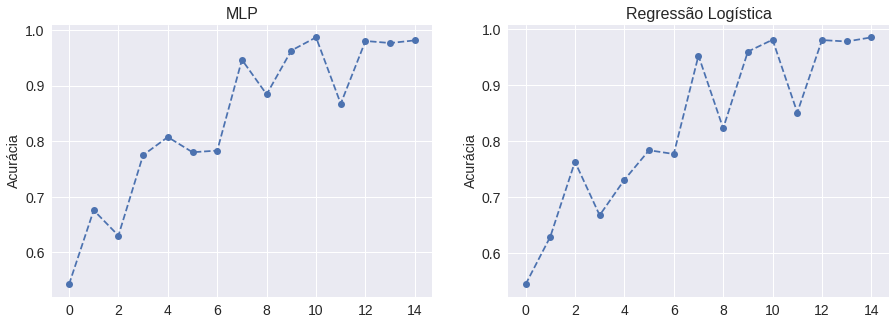

In [12]:
par = np.array(['Amp', 'Area', 'Pos_Amp', 'FWHM'])

fig = plt.figure(figsize=(15,5))
fig.add_subplot(1,2,1)
plt.plot(efc_MLP,'--o')
plt.ylabel('Acurácia')
plt.title("MLP")

fig.add_subplot(1,2,2)
plt.plot(efc_LR,'--o')
plt.ylabel('Acurácia')
plt.title("Regressão Logística")

In [13]:
par[np.asarray(lb[10])]

array(['Amp', 'Area', 'Pos_Amp'], dtype='<U7')

# Classificação

Estandartização do dataframe.

In [0]:
Y = np.array(df['Label'])  
X = df.drop(['Label'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

## MLP

- Conjunto de treino: 70%
- Conjunto de validação: 15%
- Conjunto de teste: 15%

In [0]:
xTrain, xAux, yTrain, yAux = train_test_split(X, Y, train_size = 0.7, random_state=42)        #70% treino
xEval, xTest, yEval, yTest = train_test_split(xAux, yAux, test_size = 0.5, random_state=42)   #15% validação e teste

In [0]:
err_eval  = np.array([])
err_train = np.array([])
neurons = range(1,11)
for i in neurons:
    clf = MLPClassifier(hidden_layer_sizes=(i), solver='sgd', max_iter=500, random_state=1, activation='relu')
    clf.fit(xTrain, yTrain)
    err_eval  = np.append(err_eval,  (1 - clf.score(xEval,yEval)))
    err_train = np.append(err_train, (1 - clf.score(xTrain,yTrain)))

Text(0, 0.5, 'Erro')

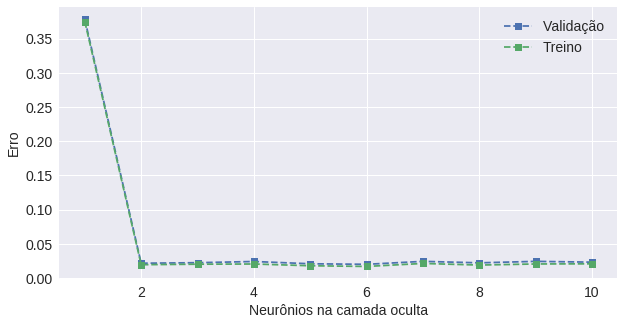

In [17]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1,11)),err_eval,'--s', label='Validação')
plt.plot(list(range(1,11)),err_train,'--s', label='Treino')
plt.legend()
plt.xlabel('Neurônios na camada oculta')
plt.ylabel('Erro')

In [18]:
print("Erro de validação mínimo: ", np.min(err_eval))
print("Número de neurônios: ", neurons[np.argmin(err_eval)])

Erro de validação mínimo:  0.020058997050147465
Número de neurônios:  6


In [19]:
n_neurons = 2        
clf = MLPClassifier(hidden_layer_sizes=(n_neurons), solver='sgd', max_iter=500, random_state=1, activation='relu')
clf.fit(xTrain, yTrain)
print("Número de neurônios utilizado: ", n_neurons)
print("Acurácia no conjunto de teste: ", round(100*clf.score(xTest,yTest),2), '%')

Número de neurônios utilizado:  2
Acurácia no conjunto de teste:  98.27 %


Labels: 
	Esperados: 1.0 	 Saturados: 2.0 	 Cortados: 3.0 	 Dois Picos: 4.0


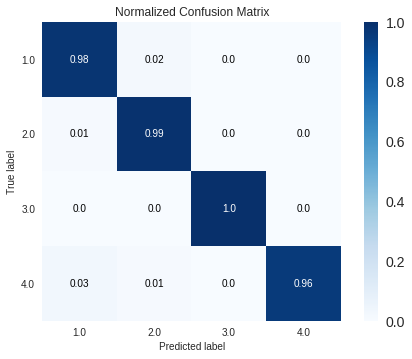

In [20]:
pred = clf.predict(xTest)
skplt.metrics.plot_confusion_matrix(yTest, pred, normalize=True)
print("Labels: \n\tEsperados: 1.0 \t Saturados: 2.0 \t Cortados: 3.0 \t Dois Picos: 4.0")

## Regressão Logística

- Conjunto de treino: 70%
- Conjunto de teste: 30%

In [0]:
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, train_size = 0.7, random_state=42)

In [22]:
clf = LogisticRegression(random_state=1, max_iter=500, solver='sag', multi_class='auto')
clf.fit(xTrain, yTrain)
print('Acurácia no conjunto de treino:\t', round(100*clf.score(xTrain,yTrain),2), '%')
print('Acurácia no conjunto de teste:\t',  round(100*clf.score(xTest,yTest),2), '%')

Acurácia no conjunto de treino:	 98.27 %
Acurácia no conjunto de teste:	 98.36 %


Labels: 
	Esperados: 1.0 	 Saturados: 2.0 	 Cortados: 3.0 	 Dois Picos: 4.0


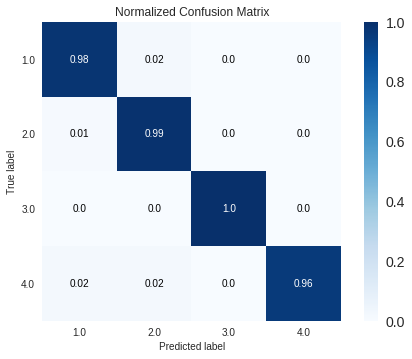

In [23]:
pred = clf.predict(xTest)
skplt.metrics.plot_confusion_matrix(yTest, pred, normalize=True)
print("Labels: \n\tEsperados: 1.0 \t Saturados: 2.0 \t Cortados: 3.0 \t Dois Picos: 4.0")

## SVM Linear

- Conjunto de treino: 70%
- Conjunto de teste: 30%

In [0]:
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, train_size = 0.7, random_state=42)

In [25]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=1, tol=1e-5, max_iter=5000)
clf.fit(xTrain, yTrain)
print('Acurácia no conjunto de treino:\t', round(100*clf.score(xTrain,yTrain),2), '%')
print('Acurácia no conjunto de teste:\t',  round(100*clf.score(xTest,yTest),2), '%')

Acurácia no conjunto de treino:	 96.36 %
Acurácia no conjunto de teste:	 96.54 %


Labels: 
	Esperados: 1.0 	 Saturados: 2.0 	 Cortados: 3.0 	 Dois Picos: 4.0


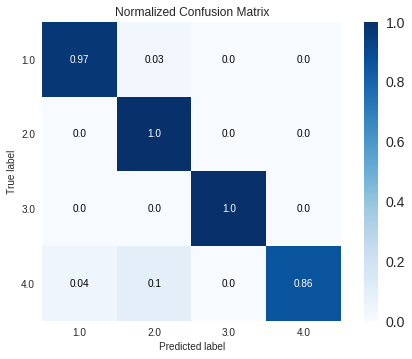

In [26]:
pred = clf.predict(xTest)
skplt.metrics.plot_confusion_matrix(yTest, pred, normalize=True)
print("Labels: \n\tEsperados: 1.0 \t Saturados: 2.0 \t Cortados: 3.0 \t Dois Picos: 4.0")